The goal is to assess the health of the watershed and to predict the major stresses to the surface water of Salt Creek, and ultimately Lake Michigan.  The state of Indiana (IDEM’s Office of Water Quality) views the following parameters as the most important in determining the health of the surface water: E. coli, Total suspended solids (TSS), Total Phosphorus (TP) and Total Nitrogen (TN).  Our study includes measurements of the first two, E. coli and TSS.  The Total Maximum Daily Loads (TMDL) for E. coli and TSS, according to IDEM, are 235 units/100 mL and 30 mg/L.  Therefore, one question is what other parameters correlate with values above the TMDL levels of E. coli and TSS?

http://shahramabyari.com/2016/01/19/detecting-outliers-in-high-dimensional-data-sets/ -- outlier detection link

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import mpld3
%matplotlib inline
from USGS_functions import drop_constant_cols, fix_timezones, merge_scale_delete, outlier_std
from IPython.display import display, HTML
from pandas_summary import DataFrameSummary     # describe function extension


#%config InlineBackend.figure_format = 'svg'

from ipywidgets import widgets
from IPython.html.widgets import *

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

#mpld3.enable_notebook()

/home/sdehmlow/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Data Downloading
Downloads data from waterqualitydata.us for the state of Indiana with a chosen set of characteristics.

In [3]:
sites_site = 'https://www.waterqualitydata.us/Station/search?statecode=US%3A18&characteristicName=Temperature%2C%20water&characteristicName=Barometric%20pressure&characteristicName=Dissolved%20oxygen&characteristicName=Conductivity&characteristicName=Escherichia%20coli&characteristicName=pH&characteristicName=Chlorine&characteristicName=Nitrate&characteristicName=Sulfate&characteristicName=Total%20suspended%20solids&characteristicName=Temperature%2C%20air&characteristicName=Wind%20direction%20(direction%20from%2C%20expressed%200-360%20deg)&characteristicName=Wind%20velocity&characteristicName=Soil%20Water&characteristicName=Precipitation&characteristicName=Cloud%20cover&characteristicName=Flow&characteristicName=Measured%20reach%20length&characteristicName=Floating%20algae%20mat%20-%20severity%20(choice%20list)&characteristicName=Algae%2C%20substrate%20rock%2Fbank%20cover%20(choice%20list)&characteristicName=RBP2%2C%20Habitat%20type%2C%20vegetated%20banks%20(%25)&characteristicName=RBP%20Local%20Watershed%20NPS%20Pollution%20(choice%20list)&characteristicName=Amount%20of%20Refuse%20on%20Banks%20(choice%20list)&characteristicName=Floating%20Garbage%20Severity%20(choice%20List)&characteristicName=Floating%20debris%20-%20severity%20(choice%20list)&characteristicName=NPS%20POLLUTION%20-%20Wildlife%20Present%20(Y%2FN)&characteristicName=NPS%20POLLUTION%20-%20Domestic%20Pets%20Present%20(Y%2FN)&characteristicName=DomLandUse&characteristicName=Species%20Rank&characteristicName=Depth&characteristicName=Turbidity&mimeType=csv&zip=yes&sorted=no'
result_site = 'https://www.waterqualitydata.us/Result/search?characteristicName=Temperature%2C%20water&characteristicName=Barometric%20pressure&characteristicName=Dissolved%20oxygen&characteristicName=Conductivity&characteristicName=Escherichia%20coli&characteristicName=pH&characteristicName=Chlorine&characteristicName=Nitrate&characteristicName=Sulfate&characteristicName=Total%20suspended%20solids&characteristicName=Temperature%2C%20air&characteristicName=Wind%20direction%20(direction%20from%2C%20expressed%200-360%20deg)&characteristicName=Wind%20velocity&characteristicName=Soil%20Water&characteristicName=Precipitation&characteristicName=Cloud%20cover&characteristicName=Flow&characteristicName=Measured%20reach%20length&characteristicName=Floating%20algae%20mat%20-%20severity%20(choice%20list)&characteristicName=Algae%2C%20substrate%20rock%2Fbank%20cover%20(choice%20list)&characteristicName=RBP2%2C%20Habitat%20type%2C%20vegetated%20banks%20(%25)&characteristicName=RBP%20Local%20Watershed%20NPS%20Pollution%20(choice%20list)&characteristicName=Amount%20of%20Refuse%20on%20Banks%20(choice%20list)&characteristicName=Floating%20Garbage%20Severity%20(choice%20List)&characteristicName=Floating%20debris%20-%20severity%20(choice%20list)&characteristicName=NPS%20POLLUTION%20-%20Wildlife%20Present%20(Y%2FN)&characteristicName=NPS%20POLLUTION%20-%20Domestic%20Pets%20Present%20(Y%2FN)&characteristicName=DomLandUse&characteristicName=Species%20Rank&characteristicName=Depth&characteristicName=Turbidity&mimeType=csv&zip=yes&sorted=no'

In [4]:
df = pd.read_csv('result.csv', parse_dates=[['ActivityStartDate',
                                             r'ActivityStartTime/Time']])
df = df.rename(columns={r'ActivityStartDate_ActivityStartTime/Time':'dateTime'})
df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
df = fix_timezones(df, 'dateTime', r'ActivityStartTime/TimeZoneCode')

#df['ResultMeasureValue'] = pd.to_numeric(df['ResultMeasureValue'], errors='coerce')

df = drop_constant_cols(df,2) # deletes columns with 2 or less unique values

# Add units to characteristic name and then drop unit column
df['CharacteristicName'] = df['CharacteristicName'] +' '+'['+df['ResultMeasure/MeasureUnitCode'].astype(str).str.rstrip()+']'
df.drop('ResultMeasure/MeasureUnitCode', axis=1, inplace=True)

Timezone column: ActivityStartTime/TimeZoneCode deleted...

ResultTimeBasisText deleted...
[nan '          ']
ResultParticleSizeBasisText deleted...
[ nan]
SubjectTaxonomicName deleted...
[ nan]
SampleTissueAnatomyName deleted...
[ nan]
Finished----------------------------------------------------------


In [5]:
dfCharacteristics = df.pivot_table(index=['MonitoringLocationIdentifier', 'dateTime'], columns='CharacteristicName', 
                             values='ResultMeasureValue', aggfunc='first').copy()
dfCharacteristics = dfCharacteristics.apply(pd.to_numeric, errors='ignore').copy() # Convert all numeric columns
dfCharacteristics.dropna(axis=0,how='all', inplace=True)                       # Delete empty Rows
dfCharacteristics.dropna(axis=1,how='all', inplace=True)                       # Delete empty Columns

# Fixing Units
First the column names are listed so that duplicates can be found. Next the units are converted and then finally the columns are merged.

In [6]:
list(dfCharacteristics)

['Barometric pressure [mm/Hg]',
 'Chlorine [mg/l]',
 'Chlorine [ug/l]',
 'Conductivity [uS/cm]',
 'Conductivity [umho/cm]',
 'Depth [cm]',
 'Depth [ft]',
 'Depth [m]',
 'Escherichia coli [#/100ml]',
 'Escherichia coli [CFU]',
 'Escherichia coli [MPN/100 ml]',
 'Escherichia coli [MPN/100ml]',
 'Escherichia coli [cfu/100ml]',
 'Escherichia coli [ug/l]',
 'Floating Garbage Severity (choice List) [code]',
 'Floating algae mat - severity (choice list) [code]',
 'Floating debris - severity (choice list) [code]',
 'Flow [cfs]',
 'Flow [ft3/sec]',
 'Flow [m3/sec]',
 'Nitrate [mg/kg as N]',
 'Nitrate [mg/l as N]',
 'Nitrate [mg/l asNO3]',
 'Nitrate [mg/l]',
 'Nitrate [ppb]',
 'Nitrate [ueq/L]',
 'Precipitation [in/week]',
 'Precipitation [in]',
 'Sulfate [mg/kg]',
 'Sulfate [mg/l]',
 'Sulfate [ppm]',
 'Sulfate [ueq/L]',
 'Temperature, air [deg C]',
 'Temperature, water [deg C]',
 'Total suspended solids [mg/l]',
 'Turbidity [FNRU]',
 'Turbidity [FNU]',
 'Turbidity [JTU]',
 'Turbidity [NTRU]',
 

# Barometric pressure

In [7]:
dfCharacteristics['Barometric pressure [mm/Hg]'] = \
                                            outlier_std(dfCharacteristics['Barometric pressure [mm/Hg]'],3,plot=False)

Before Mean=747.636110 ----- After Mean=748.114196
11 points deleted out of 174763 total.----------------------


## Chlorine
Chlorine tags are labeled with units of **mg/l** and **ug/l**. The latter is assumed to be **$\dfrac{\mu g}{l}$**.
$1mg = 10^{-3}\mu g$

In [8]:
display(dfCharacteristics.filter(regex = 'Chlorine*').dropna()) # displays overlap in the units, second value seems bad

,CharacteristicName,Chlorine [mg/l],Chlorine [ug/l]
MonitoringLocationIdentifier,dateTime,,
INSTOR_WQX-13094,2008-05-16 16:45:00,0.66,0.01


In [9]:
dfCharacteristics['Chlorine [ug/l]'].loc[dfCharacteristics['Chlorine [mg/l]'].notnull() &  \
                                         dfCharacteristics['Chlorine [ug/l]'].notnull()] = np.nan # delete bad point
scales = [1,1e-3]
columns = ['Chlorine [mg/l]','Chlorine [ug/l]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Chlorine [ug/l] deleted...


### Removing Outliers

In [10]:
dfCharacteristics['Chlorine [mg/l]'] = \
        outlier_std(outlier_std(dfCharacteristics['Chlorine [mg/l]'],1,plot=False),1,plot=False)

Before Mean=13.959876 ----- After Mean=2.705437
7 points deleted out of 174763 total.----------------------
Before Mean=2.705437 ----- After Mean=0.790913
6 points deleted out of 174763 total.----------------------


# Conductivity
Conductivity tags are labeled with units of **uS/cm**(*microSiemens*) and **umho/cm**(*micromhos*). These units are equivalent.

Typical values up to about 1500.
http://fosc.org/WQData/WQParameters.htm

In [11]:
display(dfCharacteristics.filter(regex = 'Conductivity*').dropna()) # no overlapping values

,CharacteristicName,Conductivity [uS/cm],Conductivity [umho/cm]
MonitoringLocationIdentifier,dateTime,,


In [12]:
scales = [1,1]
columns = ['Conductivity [uS/cm]','Conductivity [umho/cm]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Conductivity [umho/cm] deleted...


### Removing Outliers

In [13]:
dfCharacteristics['Conductivity [uS/cm]'] = \
    outlier_std(dfCharacteristics['Conductivity [uS/cm]'],3,plot=False)

Before Mean=354.012781 ----- After Mean=310.405866
2 points deleted out of 174763 total.----------------------


# Depth
Depth tags are labeled with units of **cm**, **ft**, and **m**. The preffered unit is the meter.
Scale Factors: $\dfrac{1m}{100cm}, \quad \dfrac{1m}{0.3048ft}$

In [14]:
display(dfCharacteristics.filter(regex = 'Depth*').dropna()) # no overlapping values

,CharacteristicName,Depth [cm],Depth [ft],Depth [m]
MonitoringLocationIdentifier,dateTime,,,


In [15]:
scales = [1,1/100,0.3048]
columns = ['Depth [m]','Depth [cm]','Depth [ft]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Depth [cm] deleted...
Depth [ft] deleted...


### Remove outliers

Before Mean=15.255071 ----- After Mean=12.990442
15 points deleted out of 174763 total.----------------------


MonitoringLocationIdentifier  dateTime           
11NPSWRD-INDU_01              2006-05-02 19:39:00   NaN
                              2006-06-27 15:17:00   NaN
                              2006-10-03 16:44:00   NaN
                              2007-05-01 14:41:00   NaN
                              2007-07-03 15:15:00   NaN
                              2007-09-04 16:10:00   NaN
                              2008-05-01 15:30:00   NaN
                              2008-07-01 14:00:00   NaN
                              2008-09-02 15:50:00   NaN
11NPSWRD-INDU_02              2006-05-03 15:55:00   NaN
                              2006-06-27 18:39:00   NaN
                              2006-10-03 14:38:00   NaN
11NPSWRD-INDU_04              2007-07-03 18:30:00   NaN
                              2007-09-04 18:50:00   NaN
                              2008-05-01 14:00:00   NaN
                              2008-07-01 16:40:00   NaN
                              2008-09-02 18:50:00   Na

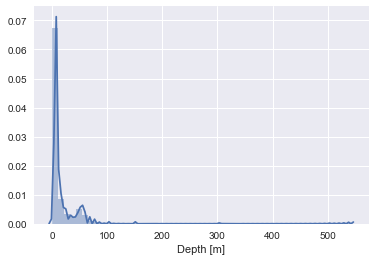

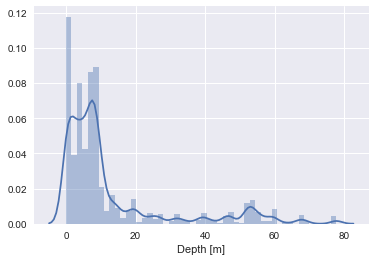

In [16]:
#dfCharacteristics['Depth [m]'] = 
outlier_std(dfCharacteristics['Depth [m]'],2,plot=True)

# Escherichia coli (E-Coli)
E-Coli tags are labeled with units of **#/100ml**, **CFU**(*Colony Forming Units*), **MPN/100 ml**, **MPN/100ml**, **cfu/100ml**, and **ug/l**. **MPN** are the Most Probable Number of CFU's in a given sample. Scaling factors are assumed all to be 1 for now.

In [17]:
display(dfCharacteristics.filter(regex = 'Escherichia*').dropna()) # no overlapping values

,CharacteristicName,Escherichia coli [#/100ml],Escherichia coli [CFU],Escherichia coli [MPN/100 ml],Escherichia coli [MPN/100ml],Escherichia coli [cfu/100ml],Escherichia coli [ug/l]
MonitoringLocationIdentifier,dateTime,,,,,,


In [18]:
scales = [1,1,1,1,1,1]
columns = ['Escherichia coli [#/100ml]',    'Escherichia coli [CFU]',
           'Escherichia coli [MPN/100 ml]', 'Escherichia coli [MPN/100ml]',
           'Escherichia coli [cfu/100ml]',  'Escherichia coli [ug/l]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Escherichia coli [CFU] deleted...
Escherichia coli [MPN/100 ml] deleted...
Escherichia coli [MPN/100ml] deleted...
Escherichia coli [cfu/100ml] deleted...
Escherichia coli [ug/l] deleted...


### Remove outliers

In [19]:
dfCharacteristics['Escherichia coli [#/100ml]'] = \
                                outlier_std(dfCharacteristics['Escherichia coli [#/100ml]'],stds=1,loops=2,plot=False)

Before Mean=1728.486327 ----- After Mean=470.393466
1379 points deleted out of 174763 total.----------------------


# Floating garbage severity

In [20]:
oldname = 'Floating Garbage Severity (choice List) [code]' 
newname = 'Floating garbage [list]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname].astype('category')

In [21]:
dfCharacteristics['Floating garbage [list]'].unique()

[NaN, None, Serious, Mild, Moderate, Extreme]
Categories (5, object): [None, Serious, Mild, Moderate, Extreme]

# Floating algae mat severity

In [22]:
oldname = 'Floating algae mat - severity (choice list) [code]'
newname = 'Floating algae mat [list]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname].astype('category')
dfCharacteristics[newname].unique()

[NaN, None, Mild, Moderate]
Categories (3, object): [None, Mild, Moderate]

In [23]:
dfCharacteristics['Floating algae mat [list]'].unique()

[NaN, None, Mild, Moderate]
Categories (3, object): [None, Mild, Moderate]

# Floating debris severity

In [24]:
oldname = 'Floating debris - severity (choice list) [code]'
newname = 'Floating debris [list]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname].astype('category')

In [25]:
dfCharacteristics['Floating debris [list]'].unique()

[NaN, Moderate, None, Mild, Serious, Extreme]
Categories (5, object): [Moderate, None, Mild, Serious, Extreme]

# Flow
Flow tags are labeled with units of **cfs**, **ft3/sec**, and **m3/sec**. **m3/sec** is the prefered unit. **cfs** and **ft3/sec** are the same and have a scaling factor: $\dfrac{0.0283168m^3}{1ft^3}$

In [26]:
display(dfCharacteristics.filter(regex = 'Flow *').dropna()) # no overlapping values

,CharacteristicName,Flow [cfs],Flow [ft3/sec],Flow [m3/sec]
MonitoringLocationIdentifier,dateTime,,,


In [27]:
scales = [1,0.0283168,0.0283168]
columns = ['Flow [m3/sec]','Flow [ft3/sec]','Flow [cfs]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Flow [ft3/sec] deleted...
Flow [cfs] deleted...


### Remove outliers

In [28]:
dfCharacteristics['Flow [m3/sec]'] = outlier_std(dfCharacteristics['Flow [m3/sec]'],stds=3,loops=3,plot=False)

Before Mean=30.074971 ----- After Mean=8.131068
270 points deleted out of 174763 total.----------------------


# Nitrate
Nitrate shows up as
Scaling factors: $\dfrac{4.4268 NO_3}{NO_3asN}, \quad \dfrac{1mg/L}{1000ppb}$

Need to find conversion for mg/kg, and ueq/l.

http://www.purewateroccasional.net/wtinitratesandnitrites.html

In [29]:
display(dfCharacteristics.filter(regex = 'Nitrate *').dropna()) # no overlapping values

,CharacteristicName,Nitrate [mg/kg as N],Nitrate [mg/l as N],Nitrate [mg/l asNO3],Nitrate [mg/l],Nitrate [ppb],Nitrate [ueq/L]
MonitoringLocationIdentifier,dateTime,,,,,,


In [30]:
scales  = [1,4.4268,1,1.,1/1000,1.]
columns = ['Nitrate [mg/l]',      'Nitrate [mg/l as N]', 'Nitrate [mg/l asNO3]',
           'Nitrate [mg/kg as N]', 'Nitrate [ppb]',       'Nitrate [ueq/L]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Nitrate [mg/l as N] deleted...
Nitrate [mg/l asNO3] deleted...
Nitrate [mg/kg as N] deleted...
Nitrate [ppb] deleted...
Nitrate [ueq/L] deleted...


In [31]:
dfCharacteristics['Nitrate [mg/l]'] = outlier_std(dfCharacteristics['Nitrate [mg/l]'],stds=3,loops=1,plot=False)

Before Mean=7.709666 ----- After Mean=6.708701
142 points deleted out of 174763 total.----------------------


# Precipitation
Assume that these are the same units.

In [32]:
display(dfCharacteristics.filter(regex = 'Precipitation *').dropna()) # no overlapping values

,CharacteristicName,Precipitation [in/week],Precipitation [in]
MonitoringLocationIdentifier,dateTime,,


In [33]:
scales = [1,1]
columns = ['Precipitation [in/week]','Precipitation [in]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Precipitation [in] deleted...


### Remove outliers

In [34]:
dfCharacteristics['Precipitation [in/week]'] = \
                                outlier_std(dfCharacteristics['Precipitation [in/week]'],stds=5,loops=1,plot=False)

Before Mean=0.837584 ----- After Mean=0.693548
1 points deleted out of 174763 total.----------------------


# Sulfate
mg/l chosen

In [35]:
display(dfCharacteristics.filter(regex = 'Sulfate *').dropna()) # no overlapping values

,CharacteristicName,Sulfate [mg/kg],Sulfate [mg/l],Sulfate [ppm],Sulfate [ueq/L]
MonitoringLocationIdentifier,dateTime,,,,


In [36]:
scales = [1,1.,1,1.]
columns = ['Sulfate [mg/l]', 'Sulfate [mg/kg]', 'Sulfate [ppm]', 'Sulfate [ueq/L]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Sulfate [mg/kg] deleted...
Sulfate [ppm] deleted...
Sulfate [ueq/L] deleted...


### Remove outliers

In [37]:
dfCharacteristics['Sulfate [mg/l]'] = outlier_std(dfCharacteristics['Sulfate [mg/l]'],stds=2,loops=1,plot=False)

Before Mean=82.374581 ----- After Mean=58.455656
944 points deleted out of 174763 total.----------------------


# Air Temperature

In [38]:
dfCharacteristics['Temperature, air [deg C]'].describe(include='all')

count    76.000000
mean     23.543816
std       5.520721
min      10.000000
25%      19.925000
50%      24.000000
75%      27.000000
max      33.160000
Name: Temperature, air [deg C], dtype: float64

### Remove outliers

In [39]:
outlier_std(dfCharacteristics['Temperature, air [deg C]'],stds=3,loops=1,plot=False);

Before Mean=23.543816 ----- After Mean=23.543816
0 points deleted out of 174763 total.----------------------


# Water Temperature

In [40]:
dfCharacteristics['Temperature, water [deg C]'].describe(include='all')

count    131453.000000
mean         15.972765
std           8.861253
min          -5.566875
25%          10.710000
50%          16.960000
75%          22.000000
max        1214.000000
Name: Temperature, water [deg C], dtype: float64

In [41]:
dfCharacteristics['Temperature, water [deg C]'] = \
                            outlier_std(dfCharacteristics['Temperature, water [deg C]'],stds=3,loops=1,plot=False)

Before Mean=15.972765 ----- After Mean=15.926957
41 points deleted out of 174763 total.----------------------


# Total suspended solids

Raw sewage is 350mg/L so probably shouldn't be any higher than that.

http://www.deltaenvironmental.com.au/management/Lab_methods/suspended_solids.htm

In [42]:
dfCharacteristics['Total suspended solids [mg/l]'].describe(include='all')

count    66577.000000
mean        40.159208
std        215.275965
min         -1.000000
25%          8.000000
50%         16.000000
75%         38.000000
max      35800.000000
Name: Total suspended solids [mg/l], dtype: float64

### Remove outliers

In [43]:
dfCharacteristics['Total suspended solids [mg/l]'] = \
                        outlier_std(dfCharacteristics['Total suspended solids [mg/l]'],stds=1.5,loops=1,plot=False)

Before Mean=40.159208 ----- After Mean=32.304207
624 points deleted out of 174763 total.----------------------


# Turbidity
NTU chosen

Can be up to 1000 NTU

www.waterboards.ca.gov/water_issues/programs/swamp/docs/cwt/guidance/3150en.pdf

In [44]:
display(dfCharacteristics.filter(regex = 'Turbidity *').dropna()) # no overlapping values

,CharacteristicName,Turbidity [FNRU],Turbidity [FNU],Turbidity [JTU],Turbidity [NTRU],Turbidity [NTU],Turbidity [None],Turbidity [mg/l SiO2],Turbidity [mg/l],Turbidity [pCi/L],Turbidity [pg/l]
MonitoringLocationIdentifier,dateTime,,,,,,,,,,


In [45]:
dfCharacteristics.filter(regex = 'Turbidity *').describe()

CharacteristicName,Turbidity [FNRU],Turbidity [FNU],Turbidity [JTU],Turbidity [NTRU],Turbidity [NTU],Turbidity [None],Turbidity [mg/l SiO2],Turbidity [mg/l],Turbidity [pCi/L],Turbidity [pg/l]
count,14.000000,832.000000,390.000000,1232.000000,97663.000000,1.00,56.000000,26.000000,4.00000,2.000000
mean,46.935714,35.505769,48.135897,44.517776,40.695703,5.43,8.625000,35.033846,51.53000,87.150000
std,94.517378,83.167806,98.764395,65.434566,116.916206,NaN,7.800519,101.337722,72.14864,98.782817
min,0.000000,0.000000,1.000000,0.100000,-577.000000,5.43,0.000000,1.900000,7.82000,17.300000
25%,14.500000,7.000000,4.000000,6.800000,7.110000,5.43,1.750000,3.250000,10.80500,52.225000
50%,21.000000,16.000000,10.500000,20.000000,14.300000,5.43,5.500000,5.390000,19.65000,87.150000
75%,32.000000,39.000000,46.500000,57.000000,34.100000,5.43,15.000000,6.612500,60.37500,122.075000
max,370.000000,1470.000000,1100.000000,900.000000,5999.000000,5.43,30.000000,502.000000,159.00000,157.000000


In [46]:
scales  = [1,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]
columns = ['Turbidity [NTU]',  'Turbidity [FNRU]', 'Turbidity [FNU]',       'Turbidity [JTU]',
           'Turbidity [NTRU]', 'Turbidity [None]', 'Turbidity [mg/l SiO2]', 'Turbidity [mg/l]',
           'Turbidity [pCi/L]','Turbidity [pg/l]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Turbidity [FNRU] deleted...
Turbidity [FNU] deleted...
Turbidity [JTU] deleted...
Turbidity [NTRU] deleted...
Turbidity [None] deleted...
Turbidity [mg/l SiO2] deleted...
Turbidity [mg/l] deleted...
Turbidity [pCi/L] deleted...
Turbidity [pg/l] deleted...


### Remove outliers

In [47]:
dfCharacteristics.loc[dfCharacteristics['Turbidity [NTU]'] < 0,['Turbidity [NTU]']] = np.nan # delete negatives
dfCharacteristics['Turbidity [NTU]'] = outlier_std(dfCharacteristics['Turbidity [NTU]'],stds=9,loops=1,plot=False)

Before Mean=40.729828 ----- After Mean=37.633082
154 points deleted out of 174763 total.----------------------


# Wind direction

In [48]:
oldname = 'Wind direction (direction from, expressed 0-360 deg) [Deg]'
newname = 'Wind direction [deg]'
dfCharacteristics = dfCharacteristics.rename(columns = {oldname : newname})
dfCharacteristics[newname] = dfCharacteristics[newname]

### Remove outliers

In [49]:
outlier_std(dfCharacteristics['Wind direction [deg]'],stds=3,loops=1,plot=False);

Before Mean=187.314815 ----- After Mean=187.314815
0 points deleted out of 174763 total.----------------------


# Wind velocity
m/s chosen

In [50]:
display(dfCharacteristics.filter(regex = 'Wind velocity *').dropna()) # no overlapping values

,CharacteristicName,Wind velocity [m/sec],Wind velocity [mph]
MonitoringLocationIdentifier,dateTime,,


In [51]:
scales  = [1,0.44704]
columns = ['Wind velocity [m/sec]','Wind velocity [mph]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

Wind velocity [mph] deleted...


### Remove outliers

In [52]:
outlier_std(dfCharacteristics['Wind velocity [m/sec]'],stds=3,loops=1,plot=False);

Before Mean=5.109117 ----- After Mean=5.109117
0 points deleted out of 174763 total.----------------------


# pH

In [53]:
display(dfCharacteristics.filter(regex = 'pH *').dropna()) # no overlapping values

,CharacteristicName,pH [None],pH [],pH [mg/l],pH [std units]
MonitoringLocationIdentifier,dateTime,,,,


In [54]:
scales  = [1,1,1,1]
columns = ['pH [None]', 'pH []', 'pH [mg/l]', 'pH [std units]']
dfCharacteristics = merge_scale_delete(dfCharacteristics,columns,scales)

pH [] deleted...
pH [mg/l] deleted...
pH [std units] deleted...


### Remove outliers

In [55]:
dfCharacteristics['pH [None]'] = outlier_std(dfCharacteristics['pH [None]'],stds=5,loops=2,plot=False)

Before Mean=7.899163 ----- After Mean=7.899815
1164 points deleted out of 174763 total.----------------------


# Export

In [56]:
dfCharacteristics.to_pickle('characteristics.p')
dfCharacteristics.to_csv('characteristics.csv')

In [57]:
list(dfCharacteristics)

['Barometric pressure [mm/Hg]',
 'Chlorine [mg/l]',
 'Conductivity [uS/cm]',
 'Depth [m]',
 'Escherichia coli [#/100ml]',
 'Floating garbage [list]',
 'Floating algae mat [list]',
 'Floating debris [list]',
 'Flow [m3/sec]',
 'Nitrate [mg/l]',
 'Precipitation [in/week]',
 'Sulfate [mg/l]',
 'Temperature, air [deg C]',
 'Temperature, water [deg C]',
 'Total suspended solids [mg/l]',
 'Turbidity [NTU]',
 'Wind direction [deg]',
 'Wind velocity [m/sec]',
 'pH [None]']

In [58]:
dfs = DataFrameSummary(dfCharacteristics)

In [59]:
dfs.summary()

,Barometric pressure [mm/Hg],Chlorine [mg/l],Conductivity [uS/cm],Depth [m],Escherichia coli [#/100ml],Floating garbage [list],Floating algae mat [list],Floating debris [list],Flow [m3/sec],Nitrate [mg/l],Precipitation [in/week],Sulfate [mg/l],"Temperature, air [deg C]","Temperature, water [deg C]",Total suspended solids [mg/l],Turbidity [NTU],Wind direction [deg],Wind velocity [m/sec],pH [None]
count,5727,37,112,1409,38742,NaN,NaN,NaN,3352,10425,744,56840,76,131412,65953,99846,54,30,142374
mean,748.114,0.790913,310.406,15.2551,470.393,NaN,NaN,NaN,8.13107,6.7087,0.693548,58.4557,23.5438,15.927,32.3042,37.6331,187.315,5.10912,7.89981
std,9.57433,1.77845,393.808,32.4316,642.962,NaN,NaN,NaN,16.7047,8.60107,0.773137,57.413,5.52072,7.54608,44.373,79.8651,107.838,2.72343,0.445329
min,711,0,8,0,-4,NaN,NaN,NaN,0,0,0,0,10,-5.56687,-1,0,0,-1,5.05
25%,742,0.01,24.75,3.3528,79.8,NaN,NaN,NaN,0.113267,0.9,0.1475,29,19.925,10.71,8,7.1,101.25,3.3528,7.69
50%,748,0.14,37.5,7.3152,220,NaN,NaN,NaN,0.758015,3.42,0.44,44,24,16.96,16,14.3,220,4.4704,7.96
75%,754,0.97,536.75,13.716,579.4,NaN,NaN,NaN,6.64171,8.8536,0.97,66,27,22,37,34.2,270,6.7056,8.18
max,795,8.3,1758.5,541.02,4150,NaN,NaN,NaN,94.21,50.9,6.74,576,33.16,42,363,1068,315,11.176,10.5
counts,5727,37,112,1409,38742,605,541,684,3352,10425,744,56840,76,131412,65953,99846,54,30,142374
uniques,76,27,80,230,1482,5,3,5,2576,1773,211,2373,50,4547,838,4624,11,12,1662


In [60]:
#for (i,j,k) in itertools.combinations(range(0,len(dfCharacteristics.columns)),3):
#    if len(dfCharacteristics.iloc[:,(i,j,k)].dropna()) > 1:
#        try:
#            sns.interactplot(dfCharacteristics.iloc[:,(i,j,k)].columns.values[0],
#                             dfCharacteristics.iloc[:,(i,j,k)].columns.values[1],
#                             dfCharacteristics.iloc[:,(i,j,k)].columns.values[2],
#                             dfCharacteristics)
#        except:
#            continue

In [61]:
#from bokeh.plotting import figure, show
#from bokeh.io import output_notebook
#p = figure()
#p.circle(dfCharacteristics['dateTime'], dfCharacteristics['Sulfate [mg/l]'])
#output_notebook()
#show(p)

In [62]:
display(dfCharacteristics.iloc[0,:])

CharacteristicName
Barometric pressure [mm/Hg]        NaN
Chlorine [mg/l]                    NaN
Conductivity [uS/cm]               NaN
Depth [m]                          NaN
Escherichia coli [#/100ml]         NaN
Floating garbage [list]            NaN
Floating algae mat [list]          NaN
Floating debris [list]             NaN
Flow [m3/sec]                      NaN
Nitrate [mg/l]                     NaN
Precipitation [in/week]            NaN
Sulfate [mg/l]                     NaN
Temperature, air [deg C]            19
Temperature, water [deg C]       17.05
Total suspended solids [mg/l]      NaN
Turbidity [NTU]                    NaN
Wind direction [deg]               NaN
Wind velocity [m/sec]              NaN
pH [None]                         7.75
Name: (11NPSWRD-INDU_01, 2006-05-02 19:39:00), dtype: object

In [63]:
dfCharacteristics.var(level=0)

CharacteristicName,Barometric pressure [mm/Hg],Chlorine [mg/l],Conductivity [uS/cm],Depth [m],Escherichia coli [#/100ml],Flow [m3/sec],Nitrate [mg/l],Precipitation [in/week],Sulfate [mg/l],"Temperature, air [deg C]","Temperature, water [deg C]",Total suspended solids [mg/l],Turbidity [NTU],Wind direction [deg],Wind velocity [m/sec],pH [None]
MonitoringLocationIdentifier,,,,,,,,,,,,,,,,
11NPSWRD-INDU_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.770000,8.122769,NaN,NaN,2160.000000,NaN,0.419878
11NPSWRD-INDU_02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.333333,17.008033,NaN,NaN,NaN,NaN,0.078533
11NPSWRD-INDU_04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.253333,15.474530,NaN,NaN,24975.000000,NaN,0.049120
11NPSWRD-INDU_05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.123333,45.550333,NaN,NaN,12825.000000,NaN,1.418492
11NPSWRD-LIBO_L1_ES3,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11NPSWRD-LIBO_L1_LINSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11NPSWRD-LIBO_L1_SGPL,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11NPSWRD-LIBO_L1_STPOND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11NPSWRD-LIBO_L1_UDSR345,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
dfCharacteristics.corr()

CharacteristicName,Barometric pressure [mm/Hg],Chlorine [mg/l],Conductivity [uS/cm],Depth [m],Escherichia coli [#/100ml],Flow [m3/sec],Nitrate [mg/l],Precipitation [in/week],Sulfate [mg/l],"Temperature, air [deg C]","Temperature, water [deg C]",Total suspended solids [mg/l],Turbidity [NTU],Wind direction [deg],Wind velocity [m/sec],pH [None]
CharacteristicName,,,,,,,,,,,,,,,,
Barometric pressure [mm/Hg],1.000000,NaN,NaN,0.021087,-0.048157,NaN,0.013012,NaN,0.022065,NaN,-0.183716,NaN,0.023574,NaN,0.439644,0.002229
Chlorine [mg/l],NaN,1.000000,NaN,NaN,-0.043591,-0.281830,NaN,NaN,-0.016406,NaN,-0.311956,-0.003644,0.004794,NaN,NaN,-0.185804
Conductivity [uS/cm],NaN,NaN,1.000000,-0.293787,NaN,-0.240771,-0.125810,NaN,-0.484036,NaN,-0.184121,-0.138673,0.001810,NaN,NaN,0.698957
Depth [m],0.021087,NaN,-0.293787,1.000000,NaN,0.665460,-0.222808,NaN,-0.072611,1.000000,-0.060722,0.365579,-0.067119,NaN,NaN,0.123414
Escherichia coli [#/100ml],-0.048157,-0.043591,NaN,NaN,1.000000,-0.101693,-0.006550,NaN,-0.047429,NaN,-0.009616,0.272197,0.250641,NaN,NaN,-0.127677
Flow [m3/sec],NaN,-0.281830,-0.240771,0.665460,-0.101693,1.000000,-0.058349,NaN,0.037753,NaN,0.027358,0.128066,0.288306,NaN,NaN,0.015614
Nitrate [mg/l],0.013012,NaN,-0.125810,-0.222808,-0.006550,-0.058349,1.000000,-0.290262,-0.006029,NaN,-0.070093,0.216355,0.081913,NaN,-0.539769,0.056404
Precipitation [in/week],NaN,NaN,NaN,NaN,NaN,NaN,-0.290262,1.000000,-0.186188,NaN,NaN,NaN,NaN,NaN,NaN,-0.190749
Sulfate [mg/l],0.022065,-0.016406,-0.484036,-0.072611,-0.047429,0.037753,-0.006029,-0.186188,1.000000,NaN,0.015652,-0.073443,-0.079142,NaN,0.229791,-0.032150
